In [26]:
using LinearAlgebra, Random, Statistics, Plots
# read data 
using MLDatasets, ImageCore

## Loading data

Let's load in the data, and transform the ys into usable psi's for multiclass classification.

In [27]:
_, ytrain = MNIST.traindata()
_,  ytest  = MNIST.testdata()

Xtrain = convert(Array{Float64}, reshape(MNIST.traintensor(), 28*28, :)');
Xtest = convert(Array{Float64}, reshape(MNIST.testtensor(), 28*28, :)');

In [28]:
MNIST.convert2image(MNIST.traintensor(5))

In [4]:
function convert2psi(ys, n = 10)
    psis = -1.0*ones(length(ys), n)
    for i in 1:length(ys)
        psis[i, ys[i] + 1] = 1.0
    end
    return psis
end

psiTrain = convert2psi(ytrain)
psiTest = convert2psi(ytest)

10000×10 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  ⋮                             ⋮                      
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0

## Function Definitions

Here, let's put most of the functions we'll need for both the forward and the backward passes.

We'll need several different types of losses, and we need data transformations like "ReLU".

For everything, we will also code up an explicit derivative, for the backward pass.

In [5]:
function logisticLoss(y_true, y_pred)
    return log.(exp.(-y_true.*y_pred).+ 1)
end

function l2Loss(y_true, y_pred)
    return (y_pred - y_true).^2
end

function l1Loss(y_true, y_pred)
    return abs.(y_pred - y_true)
end

ReLU(x) = max(x, 0)
function hinge(y_true, y_pred)
    return ReLU.((-y_true.*y_pred).+1)
end

hinge (generic function with 1 method)

In [6]:
sign(1)

1

In [7]:
sign(0)

0

In [8]:
function logisticDerivative(y_true, y_pred)
    exps = exp.(-y_true.*y_pred)
    (-y_true.*exps)./(exps.+1)
end

function l2derivative(y_true, y_pred)
    return (y_pred - y_true).*2
end

function l1derivative(y_true, y_pred)
    return sign.(y_pred - y_true)
end

function hingeDerivative(y_true, y_pred)
    return sign.(hinge(y_true, y_pred)).*(-y_true)
end

function ReLUDerivative(vals)
    return 0.5 + 0.5.*sign.(vals)
end

ReLUDerivative (generic function with 1 method)

In [9]:
function predictedClass(preds)
    _, h = findmax(preds, dims=2)
    ypred = [element[2] - 1 for element in h]
    return ypred
end

function accuracy(y, ypred)
    # Unlike the other losses, this one takes the actual class labels as input, not the transformed inputs (psis)
    return sum(y.==ypred)/length(y)
end

accuracy (generic function with 1 method)

In [10]:
function linDerivatives(X, outDers)
    bDer = zeros(size(outDers)[2])
    WDer = zeros(size(outDers)[2]).*transpose(zeros(size(X)[2]))
    for i in 1:(size(X)[1])
        bDer += outDers[i, :]
        WDer += outDers[i, :].*transpose(X[i, :])
    end
    return WDer, bDer
end

function inputDerivatives(W, outDers)
    return transpose(tranpose(W)*transpose(outDers))
end

inputDerivatives (generic function with 1 method)

## Training and testing

Let's initialize our linear parameters and bias terms.

In [11]:
d = size(Xtrain)[2] # number of features
k = size(psiTrain)[2] # number of classes

W = randn(d, k)./(d^0.5) #Useful regularization to make the coefficient vectors in the unit ball
b = randn(k)

10-element Array{Float64,1}:
 -0.4641370237309463
 -0.47110490207586014
 -0.8387375192027073
  0.02764927966846237
 -0.09639957606342836
 -0.22812726320209034
 -0.17945634000902683
  0.23182151583923488
 -0.41360962833682724
 -0.40677849198687344

Next, let's compute the predicted values. For the simplest model, we'll just fit a linear classifier.

In [12]:
preds = Xtrain*W.+transpose(b)

60000×10 Array{Float64,2}:
 -0.319758   -0.422926  -0.812925  …   0.490606   -0.564641   -0.193524
 -0.375889   -0.860701  -0.619426      0.481782    0.11881     0.0806989
 -0.440771   -0.487886  -0.708133     -0.101899   -0.521818   -0.594925
  0.294277   -0.56418   -1.16859       0.280348   -0.127825   -0.661274
 -0.0933779  -0.265844  -0.96845       0.976265   -0.466201   -0.937478
 -0.371818   -0.369583  -1.05786   …   0.678625   -0.149603   -0.622137
 -0.0805022  -0.800701  -0.823708      0.433598   -0.638289   -0.612803
 -0.107048   -0.43371   -1.07481       0.920379   -0.389732   -0.588834
 -0.429193   -0.538544  -0.902142      0.401232   -0.479674   -0.518863
 -0.390405   -0.355665  -1.13595       0.0876626  -0.340509   -0.582507
  0.10338    -0.426792  -0.704931  …   1.13035    -0.663516   -0.388786
 -0.0594018  -0.910421  -0.962118      0.219369   -0.46492    -0.493128
 -0.0519889  -0.460462  -0.82127       0.712741   -0.745858   -0.471612
  ⋮                                ⋱

Next, let's compute the loss.

In [13]:
Losses = l2Loss(psiTrain, preds)
L = sum(Losses)
println(L)

# println(accuracy(ytrain[1:100], predictedClass(t)))

473753.4241210061


Because the total loss is just the sum of the individual losses, the partial derivative of $L$ with respect to every element of $Losses$ is just $1$. So, we don't need to be careful when we compute the derivatives of the losses with respect to the outputs of our linear transformation.

In [14]:
outDers = l2derivative(psiTrain, preds)

60000×10 Array{Float64,2}:
  1.36048    1.15415    0.37415    …   2.98121   0.870718   1.61295
 -2.75178    0.278597   0.761149       2.96356   2.23762    2.1614
  1.11846    1.02423    0.583733       1.7962    0.956364   0.81015
  2.58855   -3.12836   -0.337186       2.5607    1.74435    0.677453
  1.81324    1.46831    0.0631002      3.95253   1.0676    -3.87496
  1.25636    1.26083   -4.11573    …   3.35725   1.70079    0.755727
  1.839     -3.6014     0.352584       2.8672    0.723421   0.774393
  1.7859     1.13258   -0.149627       3.84076   1.22054    0.822332
  1.14161   -3.07709    0.195716       2.80246   1.04065    0.962275
  1.21919    1.28867   -0.271894       2.17533   1.31898    0.834986
  2.20676    1.14642    0.590139   …   4.2607    0.672969   1.22243
  1.8812     0.179158   0.0757646      2.43874   1.07016    1.01374
  1.89602    1.07908    0.357461       3.42548   0.508283   1.05678
  ⋮                                ⋱                       
  1.94972    0.504794   

Finally, we use those output derivatives to compute the derivatives with respect to the paramaters of the linear classifier.

In [15]:
Wder, bder = linDerivatives(Xtrain, outDers)
#Wder

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [81972.9367684015, 28337.55701984668, -17319.792940646996, 84146.4453915524, 42654.48323232366, 59245.96113937298, 56503.0724815535, 153423.77339083224, 61897.750696251955, 27516.925787615426])

I threw together a gradient descent algorithm. Basically, it takes a step that is expected to produce an $\epsilon$ fraction reduction in the loss, where $\epsilon$ defaults to $0.01$. I also added some steps to avoid numerical instability.

Usually, one would use an out-of-the-box solver at this stage, like SGD or Adam.

In [16]:
function layer1step(Loss, W, b, Wder, bder, eps = 0.01)
    targetChange = eps*Loss
    expectedChange = sum(bder.^2) + sum(Wder.^2) + 1.0
    r = min(abs(targetChange/expectedChange), 1)
    #println(r)
    return W - transpose(Wder).*r, b - bder.*r
end
W, b = layer1step(L, W, b, Wder, bder)

([-0.0502854326217685 0.054147742501126354 … -0.06875324138813962 0.06849143064203536; 0.048698414129531666 -0.049850724540597906 … -0.04130227741108595 0.04006269684993731; … ; 0.04811031081542833 0.01731555866545333 … 0.0003584926069643947 -0.009435667316400439; -0.022290144577168124 0.04799751970861472 … 0.0014758492278178006 0.02536843610920732], [-0.464334141273838, -0.471173044438834, -0.8386958708836103, 0.02744693556304721, -0.09650214585364861, -0.22826972995692976, -0.1795922110324704, 0.2314525828910666, -0.41375847176014197, -0.4068446610057353])

## Simple, Linear Classifier

Now that we have all the tools, let's fit just a simple linear classifier with $L2$ loss, and see what the end accuracy is.

In [ ]:
n_iters = 50

d = size(Xtrain)[2] # number of features
k = size(psiTrain)[2] # number of classes

W = randn(d, k)./(d^0.5) #Useful regularization to make the coefficient vectors in the unit ball
b = randn(k)

Ls = zeros(n_iters)
accsTrain = zeros(n_iters)
accsTest = zeros(n_iters)

for i in 1:n_iters
    preds = Xtrain*W.+transpose(b)
    Losses = l2Loss(psiTrain, preds)
    L = sum(Losses)
    Ls[i] = L
    accTrain = accuracy(ytrain, predictedClass(preds))
    accsTrain[i] = accTrain
    accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
    accsTest[i] = accTest
    println("\n\nIteration")
    println(i)
    println("Loss")
    println(L)
    println("Train Accuracy")
    println(accTrain)
    println("Test Accuracy")
    println(accTest)
    outDers = l2derivative(psiTrain, preds)
    Wder, bder = linDerivatives(Xtrain, outDers)
    W, b = layer1step(L, W, b, Wder, bder, 0.1)
end

┌ Warning: lims should be a Tuple, not UnitRange{Int64}.
└ @ Plots /Users/craig/.julia/packages/Plots/uCh2y/src/args.jl:1542
┌ Warning: lims should be a Tuple, not UnitRange{Int64}.
└ @ Plots /Users/craig/.julia/packages/Plots/uCh2y/src/args.jl:1542


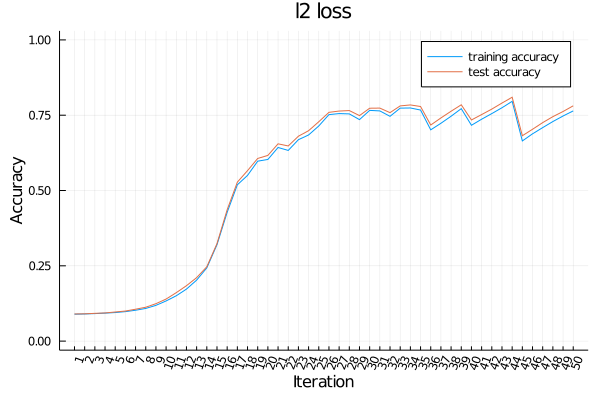

In [18]:
plot([i for i in 1:n_iters], accsTrain, xaxis = ("Iteration", 1:n_iters), yaxis = ("Accuracy", 0:1), label = "training accuracy", xrotation=70)
plot!([i for i in 1:n_iters], accsTest, xaxis = ("Iteration", 1:n_iters), yaxis = ("Accuracy", 0:1), label = "test accuracy")
title!("l2 loss")

In [19]:
println("Max train accuracy")
println(findmax(accsTrain))
println("Max test accuracy")
println(findmax(accsTest))

Max train accuracy
(0.7961, 44)
Max test accuracy
(0.8097, 44)


Because we are using such a simple model, we never had a chance to overfit; the end test accuracy is actually slightly higher than the train accuracy.

This also shows why MNIST is considered a rudimentary computer vision problem: even a linear classifier can get a fairly high accuracy.

Despite all this, lets see how much we can improve these results. What happens if, instead of the less-than-perfect L2 loss, we use a loss more fitting to the problem, such as hinge loss? After all, a label above $1$ or below $-1$ should be unambiguous.

## Hinge Loss

In [ ]:
n_iters = 50

W = randn(d, k)./(d^0.5)
b = randn(k)

Ls = zeros(n_iters)
accsTrain = zeros(n_iters)
accsTest = zeros(n_iters)

for i in 1:n_iters
    preds = Xtrain*W.+transpose(b)
    Losses = hinge(psiTrain, preds)
    L = sum(Losses)
    Ls[i] = L
    accTrain = accuracy(ytrain, predictedClass(preds))
    accsTrain[i] = accTrain
    accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
    accsTest[i] = accTest
    println("\n\nIteration")
    println(i)
    println("Loss")
    println(L)
    println("Train Accuracy")
    println(accTrain)
    println("Test Accuracy")
    println(accTest)
    outDers = hingeDerivative(psiTrain, preds)
    Wder, bder = linDerivatives(Xtrain, outDers)
    W, b = layer1step(L, W, b, Wder, bder, 0.1)
end

┌ Warning: lims should be a Tuple, not UnitRange{Int64}.
└ @ Plots /Users/craig/.julia/packages/Plots/uCh2y/src/args.jl:1542
┌ Warning: lims should be a Tuple, not UnitRange{Int64}.
└ @ Plots /Users/craig/.julia/packages/Plots/uCh2y/src/args.jl:1542


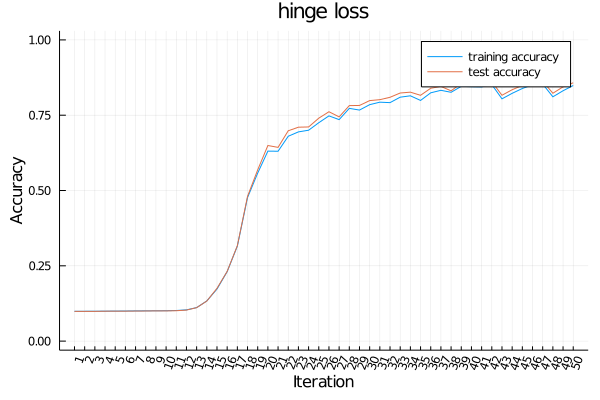

In [21]:
plot([i for i in 1:n_iters], accsTrain, xaxis = ("Iteration", 1:n_iters), yaxis = ("Accuracy", 0:1), label = "training accuracy", xrotation=70)
plot!([i for i in 1:n_iters], accsTest, xaxis = ("Iteration", 1:n_iters), yaxis = ("Accuracy", 0:1), label = "test accuracy")
title!("hinge loss")

In [22]:
println("Max train accuracy")
println(findmax(accsTrain))
println("Max test accuracy")
println(findmax(accsTest))

Max train accuracy
(0.8535666666666667, 47)
Max test accuracy
(0.8631, 47)


There seems to be a substantial improvement!

## Logistic Loss

Let's try a nonlinear function that is more expressive, and has a chance to give our model even more flexibility.

In [ ]:
n_iters = 50

W = randn(d, k)./(d^0.5)
b = randn(k)

Ls = zeros(n_iters)
accsTrain = zeros(n_iters)
accsTest = zeros(n_iters)

for i in 1:n_iters
    preds = Xtrain*W.+transpose(b)
    Losses = logisticLoss(psiTrain, preds)
    L = sum(Losses)
    Ls[i] = L
    accTrain = accuracy(ytrain, predictedClass(preds))
    accsTrain[i] = accTrain
    accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
    accsTest[i] = accTest
    println("\n\nIteration")
    println(i)
    println("Loss")
    println(L)
    println("Train Accuracy")
    println(accTrain)
    println("Test Accuracy")
    println(accTest)
    outDers = logisticDerivative(psiTrain, preds)
    Wder, bder = linDerivatives(Xtrain, outDers)
    W, b = layer1step(L, W, b, Wder, bder, 0.1)
end

┌ Warning: lims should be a Tuple, not UnitRange{Int64}.
└ @ Plots /Users/craig/.julia/packages/Plots/uCh2y/src/args.jl:1542
┌ Warning: lims should be a Tuple, not UnitRange{Int64}.
└ @ Plots /Users/craig/.julia/packages/Plots/uCh2y/src/args.jl:1542


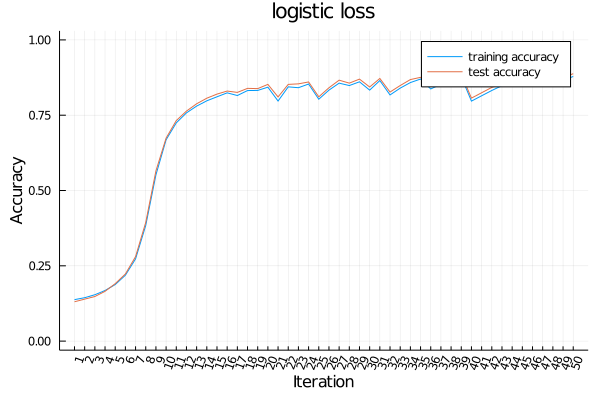

In [24]:
plot([i for i in 1:n_iters], accsTrain, xaxis = ("Iteration", 1:n_iters), yaxis = ("Accuracy", 0:1), label = "training accuracy", xrotation=70)
plot!([i for i in 1:n_iters], accsTest, xaxis = ("Iteration", 1:n_iters), yaxis = ("Accuracy", 0:1), label = "test accuracy")
title!("logistic loss")

In [25]:
println("Max train accuracy")
println(findmax(accsTrain))
println("Max test accuracy")
println(findmax(accsTest))

Max train accuracy
(0.8806666666666667, 47)
Max test accuracy
(0.8882, 47)
